In [1]:
import numpy as np
import time
from scipy.linalg import sqrtm
from tqdm import trange

eps = 1e-2
d = 5000
r = 200
G = np.random.randn(d, r)

# Naive computation vs smart computation (proposed in the paper)

Given a full-rank matrix $G \in \mathbb{R}^{d \times r}$, compute $\left(GG^T\right)^{-\frac{1}{2}}$. There are several ways to do it, let's compare their efficiencies.

## 1. Naive

In [2]:
start_time = time.time()
eigvals, eigvecs = np.linalg.eigh(G @ G.T)
result_naive = np.linalg.inv(eigvecs @ np.diag(np.sqrt(eigvals * (np.abs(eigvals) > 1e-10))) @ eigvecs.T + eps * np.eye(d))
print('Naive algorithm finished in {:.4f} seconds'.format(time.time() - start_time))

Naive algorithm finished in 16.6129 seconds


## 2. SVD of G

Decomposing $G = U\Sigma V^T$, obtaining $U_r$ and $\Sigma_r$ from here and substituting to the formula from the paper.

In [9]:
start_time = time.time()
U, sigma_r, V = np.linalg.svd(G)
U_r = U[:, :r]
result_svd_g = np.eye(d) / eps + U_r @ (np.diag(1 / (sigma_r + eps)) - np.eye(r) / eps) @ U_r.T
print('Algorithm with SVD of G finished in {:.4f} seconds'.format(time.time() - start_time))

Algorithm with SVD of G finished in 2.8071 seconds


In [10]:
np.allclose(result_naive, result_svd_g)

True

## 3. Eigendecomposition of G^TG

Decomposing $G^TG = V\Sigma_r^2V^T$, obtaining $U_r = GV\Sigma_r^{-1}$ and substituting to the formula from the paper.

In [11]:
start_time = time.time()
sigma, V = np.linalg.eigh(G.T @ G)
sigma_r = np.sqrt(sigma[::-1])
V = np.fliplr(V)
U_r = G @ V @ np.diag(1 / sigma_r)
result_eigen_gtg = np.eye(d) / eps + U_r @ (np.diag(1 / (sigma_r + eps)) - np.eye(r) / eps) @ U_r.T
print('Algorithm with eigendecomposition of G^TG finished in {:.4f} seconds'.format(time.time() - start_time))

Algorithm with eigendecomposition of G^TG finished in 0.4277 seconds


In [12]:
np.allclose(result_svd_g, result_eigen_gtg)

True

So the last method which was proposed in the paper is the most efficient way to perform a desired computation.

## 3. Plots

In [13]:
time_naive = []
time_svd_g = []
time_eigen_gtg = []

for d in trange(500, 10001, 500):
    G = np.random.randn(d, r)
    
    start_time = time.time()
    eigvals, eigvecs = np.linalg.eigh(G @ G.T)
    result_naive = np.linalg.inv(eigvecs @ np.diag(np.sqrt(eigvals * (np.abs(eigvals) > 1e-10))) @ eigvecs.T + eps * np.eye(d))
    time_naive.append(time.time() - start_time)
    
    start_time = time.time()
    U, sigma_r, V = np.linalg.svd(G)
    U_r = U[:, :r]
    result_svd_g = np.eye(d) / eps + U_r @ (np.diag(1 / (sigma_r + eps)) - np.eye(r) / eps) @ U_r.T
    time_svd_g.append(time.time() - start_time)

    start_time = time.time()
    sigma, V = np.linalg.eigh(G.T @ G)
    sigma_r = np.sqrt(sigma[::-1])
    V = np.fliplr(V)
    U_r = G @ V @ np.diag(1 / sigma_r)
    result_eigen_gtg = np.eye(d) / eps + U_r @ (np.diag(1 / (sigma_r + eps)) - np.eye(r) / eps) @ U_r.T
    time_eigen_gtg.append(time.time() - start_time)

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [13:27<00:00, 102.85s/it]


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

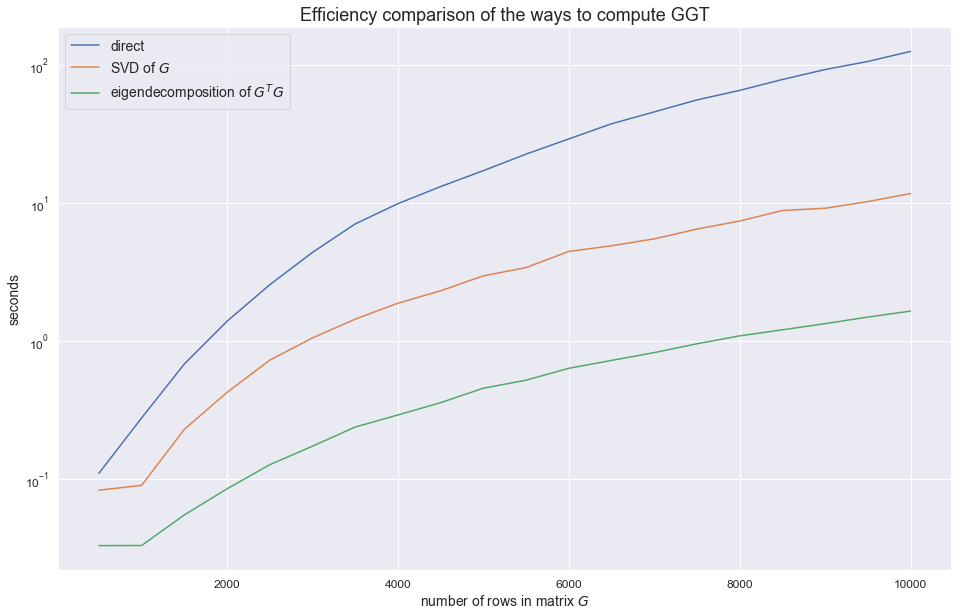

In [34]:
sns.set_style(style='darkgrid')

plt.figure(figsize=[16, 10])
plt.title('Efficiency comparison of the ways to compute GGT', fontdict={'fontsize': 18})
plt.semilogy(range(500, 10001, 500), time_naive, label='direct')
plt.semilogy(range(500, 10001, 500), time_svd_g, label='SVD of $G$')
plt.semilogy(range(500, 10001, 500), time_eigen_gtg, label='eigendecomposition of $G^TG$')
plt.legend(loc='best',  prop={'size': 14})
plt.xlabel('number of rows in matrix $G$', size=14)
plt.ylabel('seconds', size=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()